In [31]:
from code.adjustable_efficient_qsp import *
from code.adjustable_efficient_non_unitary import *
from qiskit.tools.visualization import *
import qiskit.quantum_info as qi
import matplotlib.pyplot as plt

## Real space simulation of the Heat equation

We compute the state
$$|\hat{f}_t> = QFT^{\dagger}e^{-\frac{\kappa t}{\Delta x^2}\sin(2\pi\hat{x})^2}QFT|f_0>$$
With the initial state $|f_0>$ defined with $f_0(x)=e^{-0.5(x-0.5)^2/\sigma^2}$ with $\sigma=0.1$:
$$|f_0>=\sum_x f_0(x)|x><x|$$

In [41]:
# Initial state function f_0
def gauss(x):
    sigma = 0.1
    return(np.exp(-0.5*(x-0.5)**2/(sigma**2)))

def f(x,d,dmax):
    coef = 1
    return np.arcsin(d(x)/(coef*dmax))

In [42]:
 # Generates the list of size n_operators containing the indices of Walsh operators with highest coefficients
def get_max_coeffs(n,n_operators,f):
    walsh_coeffs = {}
    for i in range(2**n):
        walsh_coeffs[i] = abs(walsh_coeff(i,f,2**n))
    w = sorted(walsh_coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement = list(dict(w).keys())[:n_operators]
    return list_operator_to_implement

# Generates the list of size n_operators containing the indices of Walsh operators with highest coefficients
# for non unitary
def get_max_coeffs_non_unitary(n,n_operators,f,d,decomposition):
    coeffs = {}
    for i in range(2**n):
        if decomposition=='walsh':
            coeffs[i] = abs(walsh_coeff_non_unitary(i,f,2**n,d))
        else:
            coeffs[i] = abs(sequential_coeff_non_unitary(i,f,2**n,d))
    w = sorted(coeffs.items(), key=lambda x:x[1],reverse=True)
    list_operator_to_implement = list(dict(w).keys())[:n_operators]
    return list_operator_to_implement

## Heat equation with Walsh decomposition

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4


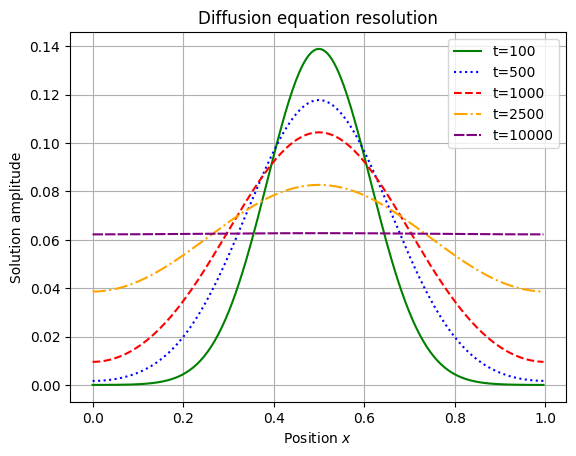

In [50]:
# Number of working qubits
n = 8

# Number of ancilla qubits for the diagonal operation
n_ancilla_diag = 0

# Number of ancilla qubits for QSP
n_ancilla_qsp = 0

# Number of Walsh operators to implement for the QSP step (maximum value is 2^n)
n_walsh_operators_qsp = 2**(n)

# We generate the list of indices of the operators to implement for QSP step
list_operator_to_implement_qsp = get_max_coeffs(n,n_walsh_operators_qsp,gauss)

# We generate the circuit for the non-unitary part
qsp_walsh = non_unitary(n,f,gauss,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_qsp,decomposition='walsh',gray_code=True,swaps=True)

# Number of Walsh operators to implement for the non_unitary step (maximum value is 2^n)
n_walsh_operators_non_unitary = 2**(n)

# List that contains the time values
t_list = [100,500,1000,2500,10000]#[0,0.005,0.02,0.05,1]

# We create some list to use for the plot
color_list = ['green','blue','red','orange','purple']
linestyle_list = ['-','dotted','dashed','dashdot',(0, (5, 1))]

# We generate the Quantum Fourier Transform gate
QFT_gate = QFT(n,do_swaps=True)

X = np.array(range(2**n))/(2**n)

# We iterate over the values of time in t_list
for k in range(len(t_list)):
    print('Iteration ',k)
    
    t = t_list[k]
    color = color_list[k]

    # We define the circuit
    q = QuantumRegister(n,name='q')
    qA = QuantumRegister(1,name='qA')
    qB = QuantumRegister(1,name='qB')
    a = AncillaRegister(n_ancilla_diag,name='a')
    a_qsp = AncillaRegister(n_ancilla_qsp,name='a_qsp')
    qc = QuantumCircuit(q,qB,qA,a,a_qsp)

    # We define the qubits
    q_qubits = qc.qubits[:n]
    qB_qubits = qc.qubits[n:n+1]
    qA_qubits = qc.qubits[n+1:n+2]
    a_qubits = qc.qubits[n+2:n+2+n_ancilla_diag]
    a_qsp_qubits = qc.qubits[n+2+n_ancilla_diag:n+2+n_ancilla_diag+n+2+n_ancilla_qsp]

    # QSP step
    qc.h(q)
    qc.append(qsp_walsh,q_qubits+qA_qubits+a_qubits+a_qsp_qubits)
    # End of QSP step
    
    # Non-unitary step    
    def d(x):
        kappa = 1
        dx = 1/2**n
        return np.exp(-t*kappa*np.sin(2*np.pi*(x-0.5))**2)
        #return np.exp(-t*(kappa/(dx**2))*(1/12)**2*(8*np.sin(2*np.pi*(x-0.5))-np.sin(4*np.pi*(x-0.5)))**2)
    
    list_operator_to_implement_non_unitary = get_max_coeffs_non_unitary(n,n_walsh_operators_non_unitary,f,d,'walsh')#[i for i in range(n_walsh_operators_non_unitary)]
    non_unitary_walsh = non_unitary(n,f,d,n_ancilla_diag,n_ancilla_qsp,list_operator_to_implement_non_unitary,decomposition='walsh',gray_code=True,swaps=True)
    qc.append(QFT_gate,q_qubits)
    qc.append(non_unitary_walsh,q_qubits+qB_qubits+a_qubits+a_qsp_qubits)
    qc.append(QFT_gate.inverse(),q_qubits)
    # End of non-unitary step
    
    state = qi.Statevector.from_instruction(qc)
    state_dict = state.to_dict()
    data = []
    n_bits = len(list(state_dict.keys())[0])
    for i in list(state_dict.keys()):
        if i[n_bits-n-1] == '1' and i[n_bits-n-2] == '1':
            data.append(state_dict[i])
    L = np.array(data)
    plt.plot(X,np.real(L)/np.linalg.norm(L),linestyle=linestyle_list[k],c=color,label='t='+str(t))
    
plt.xlabel('Position $x$')
plt.ylabel('Solution amplitude')
plt.legend()
plt.grid()
plt.title('Diffusion equation resolution')
plt.show()